# Global configuration

In [1]:
!pip install yfinance
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime
import yfinance as yf
import torch
import random
SEED=8
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

     |████████████████████████████████| 63 kB 212 kB/s eta 0:00:01
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8488 sha256=0259faaf757fb3246cd02a233e7213759e0d7b928ff1d0530ac19866d01e6988
  Stored in directory: /Users/liupeng/Library/Caches/pip/wheels/34/ba/79/c0260c6f1a03f420ec7673eff9981778f293b9107974679e36
Successfully built multitasking
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.29.0 requires typing-extensions<3.8.0,>=3.7.0, but you have typing-extensions 4.0.1 which is incompatible.


In [2]:
# check https://wrds-www.wharton.upenn.edu/ for U.S. index constituents
# Dow 30 constituents in 2021/10
DOW_30_TICKER = ["AXP", "AMGN", "AAPL", "BA", "CAT", "CSCO", "CVX", "GS", "HD",
                 "HON", "IBM", "INTC", "JNJ", "KO", "JPM", "MCD", "MMM", "MRK",
                 "MSFT", "NKE", "PG", "TRV", "UNH", "CRM", "VZ", "V", "WBA", 
                 "WMT", "DIS", "DOW"]
## stockstats technical indicator column names
## check https://pypi.org/project/stockstats/ for different names
TECHNICAL_INDICATORS_LIST = ["macd", "boll_ub", "boll_lb", "rsi_30", "cci_30",
                             "dx_30", "close_30_sma", "close_60_sma"]

# Download data

In [3]:
class YahooFinanceProcessor:
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API
    Attributes
    ----------
        start_date : str
            start date of the data (modified from neofinrl_config.py)
        end_date : str
            end date of the data (modified from neofinrl_config.py)
        ticker_list : list
            a list of stock tickers (modified from neofinrl_config.py)
    Methods
    -------
    fetch_data()
        Fetches data from yahoo API
    """

    def __init__(self):
        pass

    def download_data(
        self, start_date: str, end_date: str, ticker_list: list, time_interval: str
    ) -> pd.DataFrame:
        """Fetches data from Yahoo API
        Parameters
        ----------
        Returns
        -------
        `pd.DataFrame`
            7 columns: A date, open, high, low, close, volume and tick symbol
            for the specified stock ticker
        """

        self.start = start_date
        self.end = end_date
        self.time_interval = time_interval

        # Download and save the data in a pandas DataFrame:
        data_df = pd.DataFrame()
        for tic in ticker_list:
            temp_df = yf.download(tic, start=start_date, end=end_date)
            temp_df["tic"] = tic
            data_df = data_df.append(temp_df)
        # reset the index, we want to use numbers as index instead of dates
        data_df = data_df.reset_index()
        try:
            # convert the column names to standardized names
            data_df.columns = [
                "date",
                "open",
                "high",
                "low",
                "close",
                "adjcp",
                "volume",
                "tic",
            ]
        except NotImplementedError:
            print("the features are not supported currently")
        # create day of the week column (monday = 0)
        data_df["day"] = data_df["date"].dt.dayofweek
        # convert date to standard string format, easy to filter
        data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
        # drop missing data
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)
        # print("Display DataFrame: ", data_df.head())

        data_df = data_df.sort_values(by=["date", "tic"]).reset_index(drop=True)

        return data_df


In [4]:
dp = YahooFinanceProcessor()
df = dp.download_data(start_date = '2008-01-01',
                     end_date = '2021-10-31',
                     ticker_list = DOW_30_TICKER, time_interval='1D')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
df.head()

,date,open,high,low,close,adjcp,volume,tic,day
0,2007-12-31,7.125000,7.160714,7.062500,7.074286,6.065245,539333200,AAPL,0
1,2007-12-31,46.840000,46.880001,46.209999,46.439999,35.911190,7226000,AMGN,0
2,2007-12-31,50.849998,52.570000,50.619999,52.020000,41.228928,8380600,AXP,0
3,2007-12-31,88.139999,88.279999,87.239998,87.459999,64.097214,3184200,BA,0
4,2007-12-31,73.000000,73.709999,72.389999,72.559998,48.934669,2639600,CAT,0


In [6]:
df.shape

(101643, 9)

# Add technical indicators

In [7]:
!pip install stockstats
from stockstats import StockDataFrame as Sdf
class FeatureEngineer:
    """Provides methods for preprocessing the stock price data
    Attributes
    ----------
        use_technical_indicator : boolean
            we technical indicator or not
        tech_indicator_list : list
            a list of technical indicator names (modified from neofinrl_config.py)
        use_turbulence : boolean
            use turbulence index or not
        user_defined_feature:boolean
            user user defined features or not
    Methods
    -------
    preprocess_data()
        main method to do the feature engineering
    """

    def __init__(
        self,
        use_technical_indicator=True,
        tech_indicator_list=TECHNICAL_INDICATORS_LIST,
        use_vix=False,
        use_turbulence=False,
        user_defined_feature=False,
    ):
        self.use_technical_indicator = use_technical_indicator
        self.tech_indicator_list = tech_indicator_list
        self.use_vix = use_vix
        self.use_turbulence = use_turbulence
        self.user_defined_feature = user_defined_feature

    def preprocess_data(self, df):
        """main method to do the feature engineering
        @:param config: source dataframe
        @:return: a DataMatrices object
        """
        # clean data
        df = self.clean_data(df)

        # add technical indicators using stockstats
        if self.use_technical_indicator:
            df = self.add_technical_indicator(df)
            print("Successfully added technical indicators")

        # add vix for multiple stock
        if self.use_vix:
            df = self.add_vix(df)
            print("Successfully added vix")

        # add turbulence index for multiple stock
        if self.use_turbulence:
            df = self.add_turbulence(df)
            print("Successfully added turbulence index")

        # add user defined feature
        if self.user_defined_feature:
            df = self.add_user_defined_feature(df)
            print("Successfully added user defined features")

        # fill the missing values at the beginning and the end
        df = df.fillna(method="ffill").fillna(method="bfill")
        return df

    def clean_data(self, data):
        """
        clean the raw data
        deal with missing values
        reasons: stocks could be delisted, not incorporated at the time step
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df = df.sort_values(["date", "tic"], ignore_index=True)
        df.index = df.date.factorize()[0]
        merged_closes = df.pivot_table(index="date", columns="tic", values="close")
        merged_closes = merged_closes.dropna(axis=1)
        tics = merged_closes.columns
        df = df[df.tic.isin(tics)]
        # df = data.copy()
        # list_ticker = df["tic"].unique().tolist()
        # only apply to daily level data, need to fix for minute level
        # list_date = list(pd.date_range(df['date'].min(),df['date'].max()).astype(str))
        # combination = list(itertools.product(list_date,list_ticker))

        # df_full = pd.DataFrame(combination,columns=["date","tic"]).merge(df,on=["date","tic"],how="left")
        # df_full = df_full[df_full['date'].isin(df['date'])]
        # df_full = df_full.sort_values(['date','tic'])
        # df_full = df_full.fillna(0)
        return df

    def add_technical_indicator(self, data):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df = df.sort_values(by=["tic", "date"])
        stock = Sdf.retype(df.copy())
        unique_ticker = stock.tic.unique()

        for indicator in self.tech_indicator_list:
            indicator_df = pd.DataFrame()
            for i in range(len(unique_ticker)):
                try:
                    temp_indicator = stock[stock.tic == unique_ticker[i]][indicator]
                    temp_indicator = pd.DataFrame(temp_indicator)
                    temp_indicator["tic"] = unique_ticker[i]
                    temp_indicator["date"] = df[df.tic == unique_ticker[i]][
                        "date"
                    ].to_list()
                    indicator_df = indicator_df.append(
                        temp_indicator, ignore_index=True
                    )
                except Exception as e:
                    print(e)
            df = df.merge(
                indicator_df[["tic", "date", indicator]], on=["tic", "date"], how="left"
            )
        df = df.sort_values(by=["date", "tic"])
        return df
        # df = data.set_index(['date','tic']).sort_index()
        # df = df.join(df.groupby(level=0, group_keys=False).apply(lambda x, y: Sdf.retype(x)[y], y=self.tech_indicator_list))
        # return df.reset_i

In [8]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [9]:
df.shape

(97552, 17)

In [10]:
df.head()

,date,open,high,low,close,adjcp,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2007-12-31,7.125000,7.160714,7.062500,7.074286,6.065245,539333200,AAPL,0,0.0,7.180074,6.852783,0.0,-66.666667,100.0,7.074286,7.074286
3484,2007-12-31,46.840000,46.880001,46.209999,46.439999,35.911190,7226000,AMGN,0,0.0,7.180074,6.852783,0.0,-66.666667,100.0,46.439999,46.439999
6968,2007-12-31,50.849998,52.570000,50.619999,52.020000,41.228928,8380600,AXP,0,0.0,7.180074,6.852783,0.0,-66.666667,100.0,52.020000,52.020000
10452,2007-12-31,88.139999,88.279999,87.239998,87.459999,64.097214,3184200,BA,0,0.0,7.180074,6.852783,0.0,-66.666667,100.0,87.459999,87.459999
13936,2007-12-31,73.000000,73.709999,72.389999,72.559998,48.934669,2639600,CAT,0,0.0,7.180074,6.852783,0.0,-66.666667,100.0,72.559998,72.559998


# Add covariance matrix

In [11]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [12]:
df.shape

(90496, 19)

In [13]:
df.head()

,date,open,high,low,close,adjcp,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-30,3.122143,3.144643,3.025714,3.081786,2.642215,967601600,AAPL,1,-0.095139,3.647287,2.922999,42.673739,-80.272843,16.129793,3.246952,3.383500,"[[0.0013494488623757655, 0.0004283422043926854...",tic AAPL AMGN AXP ...
1,2008-12-30,57.000000,57.660000,56.820000,57.590000,44.533279,4300800,AMGN,1,0.206630,59.373659,55.651341,50.840501,37.623751,17.245628,56.616000,55.998167,"[[0.0013494488623757655, 0.0004283422043926854...",tic AAPL AMGN AXP ...
2,2008-12-30,17.820000,18.129999,17.700001,18.000000,14.507501,11777300,AXP,1,-1.263168,23.794809,16.256191,41.524298,-101.263980,33.966523,20.057333,22.604000,"[[0.0013494488623757655, 0.0004283422043926854...",tic AAPL AMGN AXP ...
3,2008-12-30,40.080002,41.340000,39.810001,41.250000,30.940769,4549700,BA,1,-0.597202,42.590111,38.593890,45.299685,38.696627,7.693500,40.382334,43.448167,"[[0.0013494488623757655, 0.0004283422043926854...",tic AAPL AMGN AXP ...
4,2008-12-30,42.570000,43.750000,42.009998,43.660000,30.225826,5060400,CAT,1,0.850860,45.671279,37.851721,49.916105,73.697581,19.456481,39.967000,39.993833,"[[0.0013494488623757655, 0.0004283422043926854...",tic AAPL AMGN AXP ...


In [14]:
def data_split(df, start, end, target_date_col="date"):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df[target_date_col] >= start) & (df[target_date_col] < end)]
    data = data.sort_values([target_date_col, "tic"], ignore_index=True)
    data.index = data[target_date_col].factorize()[0]
    return data

In [15]:
train = data_split(df, '2009-01-01','2020-07-01')

In [16]:
train.head()

,date,open,high,low,close,adjcp,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.778781,746015200,AAPL,4,-0.082758,3.633600,2.892864,45.439909,-30.508777,2.140065,3.244631,3.376833,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...
0,2009-01-02,58.590000,59.080002,57.750000,58.990002,45.615871,6547900,AMGN,4,0.320448,59.148360,56.339640,52.756899,94.549630,0.814217,56.759667,56.166000,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...
0,2009-01-02,18.570000,19.520000,18.400000,19.330000,15.579440,10955700,AXP,4,-1.059847,23.489423,16.086577,43.923069,-42.018825,16.335101,20.028333,22.263333,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...
0,2009-01-02,42.799999,45.560001,42.779999,45.250000,33.941090,7010200,BA,4,-0.019566,43.926849,37.932151,50.664491,275.696308,20.494464,40.621667,43.237334,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...
0,2009-01-02,44.910000,46.980000,44.709999,46.910000,32.475788,7117200,CAT,4,1.248426,46.543072,38.372928,53.534306,131.675975,34.637447,40.623333,39.911333,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...


# Design Environment

In [64]:
!pip install stable-baselines3[extra]
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        # self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = ((self.state_space+len(self.tech_indicator_list)) * self.state_space,))
        self.feat_dim = self.state_space+len(self.tech_indicator_list)

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.state = self.state.ravel()
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            self.state = self.state.ravel()
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.state = self.state.ravel()
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs


In [65]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 28, State Space: 28


In [66]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [67]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [68]:
# e_train_gym.reset().shape
e = DummyVecEnv([lambda: e_train_gym])
e.reset().shape

(1, 1008)

# Train policy

In [22]:
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

In [23]:
from stable_baselines3.common.callbacks import BaseCallback

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super(TensorboardCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])
        except BaseException:
            self.logger.record(key="train/reward", value=self.locals["reward"][0])
        return True

class DRLAgent:
    """Provides implementations for DRL algorithms
    Attributes
    ----------
        env: gym environment class
            user-defined class
    Methods
    -------
        get_model()
            setup DRL algorithms
        train_model()
            train DRL algorithms in a train dataset
            and output the trained model
        DRL_prediction()
            make a prediction in a test dataset and get results
    """

    def __init__(self, env):
        self.env = env

    def get_model(
        self,
        model_name,
        policy="MlpPolicy",
        policy_kwargs=None,
        model_kwargs=None,
        verbose=1,
        seed=None,
        tensorboard_log=None,
    ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]

        if "action_noise" in model_kwargs:
            n_actions = self.env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](
                mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
            )
        print(model_kwargs)
        model = MODELS[model_name](
            policy=policy,
            env=self.env,
            tensorboard_log=tensorboard_log,
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            seed=seed,
            **model_kwargs,
        )
        return model
    
    def train_model(self, model, tb_log_name, total_timesteps=5000):
        model = model.learn(
            total_timesteps=total_timesteps,
            tb_log_name=tb_log_name,
            callback=TensorboardCallback(),
        )
        return model

    @staticmethod
    def DRL_prediction(model, environment):
        test_env, test_obs = environment.get_sb_env()
        """make a prediction"""
        account_memory = []
        actions_memory = []
        test_env.reset()
        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs)
            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(environment.df.index.unique()) - 2):
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            if dones[0]:
                print("hit end!")
                break
        return account_memory[0], actions_memory[0]



In [24]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [25]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=1000)

-------------------------------------
| time/                 |           |
|    fps                | 343       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -39.6     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 1.85e+08  |
|    reward             | 1507138.5 |
|    std                | 0.995     |
|    value_loss         | 2.38e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 345       |
|    iterations         | 200       |
|    time_elapsed       | 2         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -39.6     |
|    explained_variance | 1.79e-07  |
|    learning_rate      | 0.0002    |
|    n_updat

# Trading

In [26]:
trade = data_split(df,'2020-07-01', '2021-10-31')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [27]:
trade.shape

(9436, 19)

In [28]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1429449.5448283376
Sharpe:  2.001964404510939
hit end!


In [29]:
df_daily_return.head()

,date,daily_return
0,2020-07-01,0.000000
1,2020-07-02,0.004743
2,2020-07-06,0.015841
3,2020-07-07,-0.010441
4,2020-07-08,0.005679


In [30]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,...,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714
2020-07-02,0.061647,0.022679,0.022679,0.045620,0.039061,0.022679,0.022679,0.022679,0.022679,0.022679,...,0.031382,0.031354,0.022679,0.061647,0.022679,0.022679,0.040835,0.061647,0.061647,0.061647
2020-07-06,0.023231,0.047250,0.063149,0.023231,0.063149,0.023231,0.063149,0.023231,0.046266,0.023231,...,0.023231,0.023231,0.054575,0.023231,0.023231,0.063149,0.035446,0.023231,0.044574,0.063149
2020-07-07,0.026101,0.026101,0.026101,0.026101,0.026101,0.047579,0.070950,0.026101,0.026101,0.026101,...,0.026101,0.026101,0.026101,0.035642,0.026101,0.044541,0.026101,0.026101,0.027152,0.070950
2020-07-08,0.072268,0.026586,0.026586,0.026586,0.044178,0.026586,0.057015,0.072268,0.026586,0.026586,...,0.026682,0.026586,0.026586,0.026586,0.026586,0.026586,0.026586,0.026586,0.049381,0.027809


In [31]:
!pip install pyfolio

def convert_daily_return_to_pyfolio_ts(df):
    strategy_ret = df.copy()
    strategy_ret["date"] = pd.to_datetime(strategy_ret["date"])
    strategy_ret.set_index("date", drop=False, inplace=True)
    strategy_ret.index = strategy_ret.index.tz_localize("UTC")
    del strategy_ret["date"]
    ts = pd.Series(strategy_ret["daily_return"].values, index=strategy_ret.index)
    return ts


     |████████████████████████████████| 91 kB 2.4 MB/s eta 0:00:011
     |████████████████████████████████| 292 kB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 109 kB 10.2 MB/s eta 0:00:01
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88667 sha256=9fb37206dfbcee51820ebd5e148ff75fbcc7e04f291582c13f1769ddd5afb71e
  Stored in directory: /Users/liupeng/Library/Caches/pip/wheels/e4/96/9b/0dfff5453e702fd780a099b7c850521099c5ec0dfafae189f9
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39764 sha256=2cd2cb0f57408b84924d39e61e74dc6ede81810fe3813e0d7fca290296feae9e
  Stored in directory: /Users/liupeng/Library/Caches/pip/wheels/d9/91/4b/654fcff57477efcf149eaca236da2fce991526cbab431bf312
Successfully built pyfolio empyrical


In [32]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

/Users/liupeng/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [33]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.306265
Cumulative returns     0.429450
Annual volatility      0.138280
Sharpe ratio           2.001964
Calmar ratio           3.795849
Stability              0.909727
Max drawdown          -0.080684
Omega ratio            1.395166
Sortino ratio          3.100965
Skew                   0.097503
Kurtosis               2.456289
Tail ratio             1.151844
Daily value at risk   -0.016323
Alpha                  0.000000
Beta                   1.000000
dtype: float64

# DDPG

In [38]:
import warnings ; warnings.filterwarnings('ignore')
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['OMP_NUM_THREADS'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import threading
from torch.distributions import Normal

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

# import pybullet_envs
import matplotlib
import subprocess
import os.path
import tempfile
import random
# import base64pybullet_envs
import pprint
import glob
import time      
import json
import sys
import gym
import io
import os
import gc

from gym import wrappers
from skimage.transform import resize
from skimage.color import rgb2gray
from subprocess import check_output
from IPython.display import display, HTML

LEAVE_PRINT_EVERY_N_SECS = 300
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('..', 'results')
SEEDS = [12, 34, 56]#, 78, 90, 100, 120, 150, 180, 200)

In [41]:
class FCQV(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCQV, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            in_dim = hidden_dims[i]
            if i == 0: 
                in_dim += output_dim
            hidden_layer = nn.Linear(in_dim, hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
    
    def _format(self, state, action):
        x, u = state, action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u, 
                             device=self.device, 
                             dtype=torch.float32)
            u = u.unsqueeze(0)
        return x, u

    def forward(self, state, action):
        x, u = self._format(state, action)
        # print(x.shape)
        x = self.activation_fc(self.input_layer(x))
        for i, hidden_layer in enumerate(self.hidden_layers):
            if i == 0:
                x = torch.cat((x, u), dim=1)
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x)
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals


class FCDP(nn.Module):
    def __init__(self, 
                 input_dim,
                 action_bounds,
                 hidden_dims=(32,32), 
                 activation_fc=F.relu,
                 out_activation_fc=F.tanh):
        super(FCDP, self).__init__()
        self.activation_fc = activation_fc
        self.out_activation_fc = out_activation_fc
        self.env_min, self.env_max = action_bounds

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], len(self.env_max))

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
        self.env_min = torch.tensor(self.env_min,
                                    device=self.device, 
                                    dtype=torch.float32)

        self.env_max = torch.tensor(self.env_max,
                                    device=self.device, 
                                    dtype=torch.float32)
        
        self.nn_min = self.out_activation_fc(
            torch.Tensor([float('-inf')])).to(self.device)
        self.nn_max = self.out_activation_fc(
            torch.Tensor([float('inf')])).to(self.device)
        self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / \
                                    (self.nn_max - self.nn_min) + self.env_min

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        # print(1)
        # print(x.shape)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        x = self.out_activation_fc(x)
        return self.rescale_fn(x)



class ReplayBuffer():
    def __init__(self, 
                 max_size=10000, 
                 batch_size=64):
        self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0
    
    def store(self, sample):
        s, a, r, p, d = sample
        self.ss_mem[self._idx] = s
        self.as_mem[self._idx] = a
        self.rs_mem[self._idx] = r
        self.ps_mem[self._idx] = p
        self.ds_mem[self._idx] = d
        
        self._idx += 1
        self._idx = self._idx % self.max_size

        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size

        idxs = np.random.choice(
            self.size, batch_size, replace=False)
        experiences = np.vstack(self.ss_mem[idxs]), \
                      np.vstack(self.as_mem[idxs]), \
                      np.vstack(self.rs_mem[idxs]), \
                      np.vstack(self.ps_mem[idxs]), \
                      np.vstack(self.ds_mem[idxs])
        return experiences

    def __len__(self):
        return self.size


class GreedyStrategy():
    def __init__(self, bounds):
        self.low, self.high = bounds
        self.ratio_noise_injected = 0

    def select_action(self, model, state):
        with torch.no_grad():
            greedy_action = model(state).cpu().detach().data.numpy().squeeze()

        action = np.clip(greedy_action, self.low, self.high)
        return np.reshape(action, self.high.shape)



class NormalNoiseStrategy():
    def __init__(self, bounds, exploration_noise_ratio=0.1):
        self.low, self.high = bounds
        self.exploration_noise_ratio = exploration_noise_ratio
        self.ratio_noise_injected = 0

    def select_action(self, model, state, max_exploration=False):
        if max_exploration:
            noise_scale = self.high
        else:
            noise_scale = self.exploration_noise_ratio * self.high

        with torch.no_grad():
            greedy_action = model(state).cpu().detach().data.numpy().squeeze()

        noise = np.random.normal(loc=0, scale=noise_scale, size=len(self.high))
        noisy_action = greedy_action + noise
        action = np.clip(noisy_action, self.low, self.high)
        
        self.ratio_noise_injected = np.mean(abs((greedy_action - action)/(self.high - self.low)))
        return action


class DDPG():
    def __init__(self, 
                 replay_buffer_fn,
                 policy_model_fn, 
                 policy_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn, 
                 value_max_grad_norm, 
                 value_optimizer_fn, 
                 value_optimizer_lr, 
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau):
        self.replay_buffer_fn = replay_buffer_fn

        self.policy_model_fn = policy_model_fn
        self.policy_max_grad_norm = policy_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr
        
        self.value_model_fn = value_model_fn
        self.value_max_grad_norm = value_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr

        self.training_strategy_fn = training_strategy_fn
        self.evaluation_strategy_fn = evaluation_strategy_fn

        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
        self.tau = tau

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)

        argmax_a_q_sp = self.target_policy_model(next_states)
        max_a_q_sp = self.target_value_model(next_states, argmax_a_q_sp)
        target_q_sa = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)
        q_sa = self.online_value_model(states, actions)
        td_error = q_sa - target_q_sa.detach()
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model.parameters(), 
                                       self.value_max_grad_norm)
        self.value_optimizer.step()

        argmax_a_q_s = self.online_policy_model(states)
        max_a_q_s = self.online_value_model(states, argmax_a_q_s)
        policy_loss = -max_a_q_s.mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_policy_model.parameters(), 
                                       self.policy_max_grad_norm)        
        self.policy_optimizer.step()

    def interaction_step(self, state, env):
        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
        action = self.training_strategy.select_action(self.online_policy_model, 
                                                      state, 
                                                      len(self.replay_buffer) < min_samples)
        new_state, reward, is_terminal, info = env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += self.training_strategy.ratio_noise_injected
        return new_state, is_terminal
    
    def update_networks(self, tau=None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_value_model.parameters(), 
                                  self.online_value_model.parameters()):
            target_ratio = (1.0 - self.tau) * target.data
            online_ratio = self.tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

        for target, online in zip(self.target_policy_model.parameters(), 
                                  self.online_policy_model.parameters()):
            target_ratio = (1.0 - self.tau) * target.data
            online_ratio = self.tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.shape[0]
        action_bounds = env.action_space.low, env.action_space.high
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.target_value_model = self.value_model_fn(nS, nA)
        self.online_value_model = self.value_model_fn(nS, nA)
        self.target_policy_model = self.policy_model_fn(nS, action_bounds)
        self.online_policy_model = self.policy_model_fn(nS, action_bounds)
        self.update_networks(tau=1.0)
        self.value_optimizer = self.value_optimizer_fn(self.online_value_model, 
                                                       self.value_optimizer_lr)        
        self.policy_optimizer = self.policy_optimizer_fn(self.online_policy_model, 
                                                         self.policy_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
        self.training_strategy = training_strategy_fn(action_bounds)
        self.evaluation_strategy = evaluation_strategy_fn(action_bounds)
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                # print(state.shape)
                # print(state)
                state, is_terminal = self.interaction_step(state, env)

                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_value_model.load(experiences)
                    self.optimize_model(experiences)

                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_networks()

                if is_terminal:
                    gc.collect()
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_policy_model, env)
            self.save_checkpoint(episode-1, self.online_policy_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:07}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.online_policy_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(eval_policy_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=4):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths

    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))
        
def get_make_env_fn(**kargs):
    def make_env_fn(env_name, seed=None, render=None, record=False,
                    unwrapped=False, monitor_mode=None, 
                    inner_wrappers=None, outer_wrappers=None):
        mdir = tempfile.mkdtemp()
        # env = None
        # if render:
        #     try:
        #         env = gym.make(env_name, render=render)
        #     except:
        #         pass
        # if env is None:
        #     env = gym.make(env_name)
        if seed is not None: 
            random.seed(seed)
            np.random.seed(seed)
            # tf.random.set_random_seed(seed)
            torch.manual_seed(seed)
        # env = env.unwrapped if unwrapped else env
        # if inner_wrappers:
        #     for wrapper in inner_wrappers:
        #         env = wrapper(env)
        # env = wrappers.Monitor(
        #     env, mdir, force=True, 
        #     mode=monitor_mode, 
        #     video_callable=lambda e_idx: record) if monitor_mode else env
        # if outer_wrappers:
        #     for wrapper in outer_wrappers:
        #         env = wrapper(env)
        env = StockPortfolioEnv(df = train, **env_kwargs)
        return env
    return make_env_fn, kargs


In [42]:
ddpg_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'StockPortfolioEnv',
        'gamma': 0.99,
        'max_minutes': 5,
        'max_episodes': 100,
        'goal_mean_100_reward': 1500000
    }

    policy_model_fn = lambda nS, bounds: FCDP(nS, bounds, hidden_dims=(256,256))
    policy_max_grad_norm = float('inf')
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.001

    value_model_fn = lambda nS, nA: FCQV(nS, nA, hidden_dims=(256,256))
    value_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_lr = 0.001

    training_strategy_fn = lambda bounds: NormalNoiseStrategy(bounds, exploration_noise_ratio=0.1)
    evaluation_strategy_fn = lambda bounds: GreedyStrategy(bounds)

    replay_buffer_fn = lambda: ReplayBuffer(max_size=50000, batch_size=128)
    n_warmup_batches = 5
    update_target_every_steps = 1
    tau = 0.05
    
    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()

    agent = DDPG(replay_buffer_fn,
                 policy_model_fn, 
                 policy_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn, 
                 value_max_grad_norm, 
                 value_optimizer_fn, 
                 value_optimizer_lr, 
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, 
        goal_mean_100_reward)
    ddpg_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
ddpg_results = np.array(ddpg_results)
_ = BEEP()

begin_total_asset:1000000
end_total_asset:4664860.553993328
Sharpe:  0.827949210521489
begin_total_asset:1000000
end_total_asset:4743500.768258629
Sharpe:  0.8407885291965188
el 00:01:11, ep 0000, ts 0002893, ar 10 7807253184.9±000.0, 100 7807253184.9±000.0, ex 100 0.1±0.0, ev 7937400152.4±000.0
--> reached_goal_mean_reward ✓


KeyboardInterrupt: 

NameError: name 'ddpg_max_r' is not defined

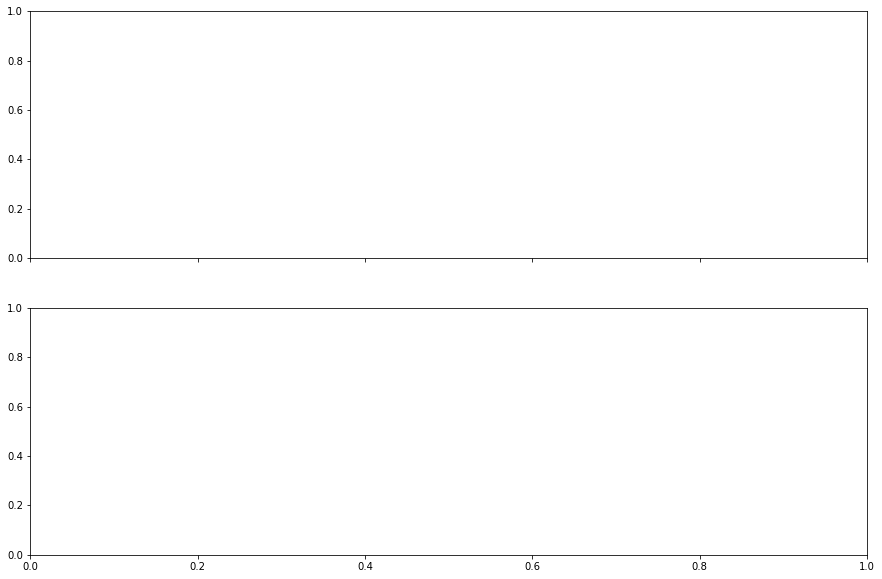

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

ddpg_results_backup = ddpg_results
ddpg_results_new = []

for i in range(len(ddpg_results)):
    if not np.isnan(ddpg_results[i][-1][-1]):
        ddpg_results_new.append(ddpg_results[i])

ddpg_results_new = np.array(ddpg_results_new)
ddpg_results = ddpg_results_new

ddpg_max_t, ddpg_max_r, ddpg_max_s, \
ddpg_max_sec, ddpg_max_rt = np.max(ddpg_results, axis=0).T
ddpg_min_t, ddpg_min_r, ddpg_min_s, \
ddpg_min_sec, ddpg_min_rt = np.min(ddpg_results, axis=0).T
ddpg_mean_t, ddpg_mean_r, ddpg_mean_s, \
ddpg_mean_sec, ddpg_mean_rt = np.mean(ddpg_results, axis=0).T
ddpg_x = np.arange(len(ddpg_mean_s))

fig, axs = plt.subplots(2, 1, figsize=(15,10), sharey=False, sharex=True)

# DDPG
axs[0].plot(ddpg_max_r, 'r', linewidth=1)
axs[0].plot(ddpg_min_r, 'r', linewidth=1)
axs[0].plot(ddpg_mean_r, 'r:', label='DDPG', linewidth=2)
axs[0].fill_between(
    ddpg_x, ddpg_min_r, ddpg_max_r, facecolor='r', alpha=0.3)

axs[1].plot(ddpg_max_s, 'r', linewidth=1)
axs[1].plot(ddpg_min_s, 'r', linewidth=1)
axs[1].plot(ddpg_mean_s, 'r:', label='DDPG', linewidth=2)
axs[1].fill_between(
    ddpg_x, ddpg_min_s, ddpg_max_s, facecolor='r', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [47]:
# trading - testing
test_env, test_obs = e_trade_gym.get_sb_env()
"""make a prediction"""
account_memory = []
actions_memory = []
test_env.reset()
for i in range(len(e_trade_gym.df.index.unique())):
    # action, _states = best_agent.predict(test_obs)
    action = best_agent.target_policy_model(test_obs)
    action = action.detach().cpu().numpy()[0]
    test_obs, rewards, dones, info = test_env.step(action)
    if i == (len(e_trade_gym.df.index.unique()) - 2):
        account_memory = test_env.env_method(method_name="save_asset_memory")
        actions_memory = test_env.env_method(method_name="save_action_memory")
    if dones[0]:
        print("hit end!")
        break

df_daily_return = account_memory[0]
df_actions = actions_memory[0]

AttributeError: 'NoneType' object has no attribute 'target_policy_model'

In [64]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")
perf_stats_all

Annual return          0.273901
Cumulative returns     0.382286
Annual volatility      0.135544
Sharpe ratio           1.854464
Calmar ratio           3.040856
Stability              0.914464
Max drawdown          -0.090074
Omega ratio            1.363125
Sortino ratio          2.792149
Skew                  -0.194691
Kurtosis               1.527521
Tail ratio             1.091295
Daily value at risk   -0.016079
Alpha                  0.000000
Beta                   1.000000
dtype: float64

# DDPG with multi-head self attention

In [56]:
!pip install einops
from einops import rearrange

In [93]:
class FCQV_MHA(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 activation_fc=F.relu,
                 num_stock = 28,
                 num_head = 3, 
                 num_batch = 128,
                 num_feat = 36, # original num of features per stock
                 node_size = 64 # num of hidden featurs for attention module
                ):
        super(FCQV_MHA, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            in_dim = hidden_dims[i]
            if i == 0: 
                in_dim += output_dim
            hidden_layer = nn.Linear(in_dim, hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

        self.num_stock = num_stock
        self.num_head = num_head
        self.num_batch = num_batch
        self.num_feat = num_feat
        self.node_size = node_size
        self.proj_shape = (self.num_feat, self.num_head * self.node_size)
        self.k_proj = nn.Linear(*self.proj_shape)
        self.q_proj = nn.Linear(*self.proj_shape)
        self.v_proj = nn.Linear(*self.proj_shape)
        self.node_shape = (self.num_head, self.num_stock, self.node_size)
        self.k_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True)
        self.q_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True)
        self.v_norm = nn.LayerNorm(self.node_shape, elementwise_affine=True)
        self.k_lin = nn.Linear(self.node_size, self.num_stock) #B
        self.q_lin = nn.Linear(self.node_size, self.num_stock)
        self.a_lin = nn.Linear(self.num_stock, self.num_stock)
        
        self.linear1 = nn.Linear(self.num_head * self.node_size, self.node_size)
        self.norm1 = nn.LayerNorm([self.num_stock, self.node_size], elementwise_affine=False)
        self.linear2 = nn.Linear(self.node_size, self.num_stock * self.num_feat)
    
    def _format(self, state, action):
        x, u = state, action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u, 
                             device=self.device, 
                             dtype=torch.float32)
            u = u.unsqueeze(0)
        return x, u

    def forward(self, state, action):
        x, u = self._format(state, action)
        
        ####### MHA #####
#         print(x.shape)
        x2 = x.reshape(self.num_batch, self.num_stock, -1)
#         print(x2.shape)
        
        K = rearrange(self.k_proj(x2), "b n (head d) -> b head n d", head=self.num_head)
        K = self.k_norm(K) 
        
        Q = rearrange(self.q_proj(x2), "b n (head d) -> b head n d", head=self.num_head)
        Q = self.q_norm(Q) 
        
        V = rearrange(self.v_proj(x2), "b n (head d) -> b head n d", head=self.num_head)
        V = self.v_norm(V) 
        
        A = torch.nn.functional.elu(self.q_lin(Q) + self.k_lin(K)) #D
        A = self.a_lin(A)
        A = torch.nn.functional.softmax(A, dim=3) 
        with torch.no_grad():
            self.att_map = A.clone() #E
        E = torch.einsum('bhfc,bhcd->bhfd',A,V) #F
        E = rearrange(E, 'b head n d -> b n (head d)')
        E = self.linear1(E)
        E = torch.relu(E)
        E = self.norm1(E)
        E = E.max(dim=1)[0]
        y = self.linear2(E)
        y = torch.nn.functional.elu(y)
#         print(y.shape)
        
        x = self.activation_fc(self.input_layer(y))
        for i, hidden_layer in enumerate(self.hidden_layers):
            if i == 0:
                x = torch.cat((x, u), dim=1)
            x = self.activation_fc(hidden_layer(x))
        
        return self.output_layer(x)
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

    
    

class FCDP_MHA(nn.Module):
    def __init__(self, 
                 input_dim,
                 action_bounds,
                 hidden_dims=(32,32), 
                 activation_fc=F.relu,
                 out_activation_fc=F.tanh):
        super(FCDP_MHA, self).__init__()
        self.activation_fc = activation_fc
        self.out_activation_fc = out_activation_fc
        self.env_min, self.env_max = action_bounds

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], len(self.env_max))

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
        self.env_min = torch.tensor(self.env_min,
                                    device=self.device, 
                                    dtype=torch.float32)

        self.env_max = torch.tensor(self.env_max,
                                    device=self.device, 
                                    dtype=torch.float32)
        
        self.nn_min = self.out_activation_fc(
            torch.Tensor([float('-inf')])).to(self.device)
        self.nn_max = self.out_activation_fc(
            torch.Tensor([float('inf')])).to(self.device)
        self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / \
                                    (self.nn_max - self.nn_min) + self.env_min

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        # print(1)
        # print(x.shape)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        x = self.out_activation_fc(x)
        return self.rescale_fn(x)

    

In [99]:
import warnings ; warnings.filterwarnings('ignore')
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['OMP_NUM_THREADS'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import threading
from torch.distributions import Normal

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

# import pybullet_envs
import matplotlib
import subprocess
import os.path
import tempfile
import random
# import base64pybullet_envs
import pprint
import glob
import time      
import json
import sys
import gym
import io
import os
import gc

from gym import wrappers
from skimage.transform import resize
from skimage.color import rgb2gray
from subprocess import check_output
from IPython.display import display, HTML

LEAVE_PRINT_EVERY_N_SECS = 300
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('..', 'results')
SEEDS = [12, 34, 56]#, 78, 90, 100, 120, 150, 180, 200)
BATCH = 128

ddpg_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'StockPortfolioEnv',
        'gamma': 0.99,
        'max_minutes': 1,
        'max_episodes': 10,
        'goal_mean_100_reward': 1500000
    }

    policy_model_fn = lambda nS, bounds: FCDP_MHA(nS, bounds, hidden_dims=(256,256))
    policy_max_grad_norm = float('inf')
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.001

    value_model_fn = lambda nS, nA: FCQV_MHA(nS, nA, hidden_dims=(256,256), num_stock = e_train_gym.stock_dim,
                                                 num_head = 3, 
                                                 num_batch = BATCH,
                                                 num_feat = e_train_gym.feat_dim, 
                                                 node_size = 64)
    value_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_lr = 0.001

    training_strategy_fn = lambda bounds: NormalNoiseStrategy(bounds, exploration_noise_ratio=0.1)
    evaluation_strategy_fn = lambda bounds: GreedyStrategy(bounds)

    replay_buffer_fn = lambda: ReplayBuffer(max_size=50000, batch_size=BATCH)
    n_warmup_batches = 5
    update_target_every_steps = 1
    tau = 0.05
    
    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()

    agent = DDPG(replay_buffer_fn,
                 policy_model_fn, 
                 policy_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn, 
                 value_max_grad_norm, 
                 value_optimizer_fn, 
                 value_optimizer_lr, 
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, 
        goal_mean_100_reward)
    ddpg_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
ddpg_results = np.array(ddpg_results)
_ = BEEP()

begin_total_asset:1000000
end_total_asset:4276531.907803205
Sharpe:  0.7918242020928153
begin_total_asset:1000000
end_total_asset:4229409.264306326
Sharpe:  0.7889318132433587
el 00:05:08, ep 0000, ts 0002893, ar 10 7563090536.3±000.0, 100 7563090536.3±000.0, ex 100 0.1±0.0, ev 7494986177.5±000.0
--> reached_max_minutes ✕
--> reached_goal_mean_reward ✓
begin_total_asset:1000000
end_total_asset:4229409.264306326
Sharpe:  0.7889318132433587
begin_total_asset:1000000
end_total_asset:4229409.264306326
Sharpe:  0.7889318132433587
begin_total_asset:1000000
end_total_asset:4229409.264306326
Sharpe:  0.7889318132433587
begin_total_asset:1000000
end_total_asset:4229409.264306326
Sharpe:  0.7889318132433587
begin_total_asset:1000000
end_total_asset:4229409.264306326
Sharpe:  0.7889318132433587
begin_total_asset:1000000
end_total_asset:4229409.264306326
Sharpe:  0.7889318132433587
begin_total_asset:1000000
end_total_asset:4229409.264306326
Sharpe:  0.7889318132433587
begin_total_asset:1000000
end

In [95]:
a = e_train_gym.reset()
a.shape

(1008,)

# a.reshape(28,-1).shape

In [69]:
e_train_gym.feat_dim

36

In [97]:
# !pip install torchsummary
# from torchsummary import summary
# summary(agent, input_size=(1008,))

  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


AttributeError: 'DDPG' object has no attribute 'apply'

In [101]:
# trading - testing
test_env, test_obs = e_trade_gym.get_sb_env()
"""make a prediction"""
account_memory = []
actions_memory = []
test_env.reset()
for i in range(len(e_trade_gym.df.index.unique())):
    # action, _states = best_agent.predict(test_obs)
    action = best_agent.target_policy_model(test_obs)
    action = action.detach().cpu().numpy()[0]
    test_obs, rewards, dones, info = test_env.step(action)
    if i == (len(e_trade_gym.df.index.unique()) - 2):
        account_memory = test_env.env_method(method_name="save_asset_memory")
        actions_memory = test_env.env_method(method_name="save_action_memory")
    if dones[0]:
        print("hit end!")
        break

df_daily_return = account_memory[0]
df_actions = actions_memory[0]

begin_total_asset:1000000
end_total_asset:1378897.8163025288
Sharpe:  1.9277075762062084
hit end!


In [102]:
import matplotlib.pyplot as plt
%matplotlib inline

ddpg_results_backup = ddpg_results
ddpg_results_new = []

for i in range(len(ddpg_results)):
    if not np.isnan(ddpg_results[i][-1][-1]):
        ddpg_results_new.append(ddpg_results[i])

ddpg_results_new = np.array(ddpg_results_new)
ddpg_results = ddpg_results_new

ddpg_max_t, ddpg_max_r, ddpg_max_s, \
ddpg_max_sec, ddpg_max_rt = np.max(ddpg_results, axis=0).T
ddpg_min_t, ddpg_min_r, ddpg_min_s, \
ddpg_min_sec, ddpg_min_rt = np.min(ddpg_results, axis=0).T
ddpg_mean_t, ddpg_mean_r, ddpg_mean_s, \
ddpg_mean_sec, ddpg_mean_rt = np.mean(ddpg_results, axis=0).T
ddpg_x = np.arange(len(ddpg_mean_s))

fig, axs = plt.subplots(2, 1, figsize=(15,10), sharey=False, sharex=True)

# DDPG
axs[0].plot(ddpg_max_r, 'r', linewidth=1)
axs[0].plot(ddpg_min_r, 'r', linewidth=1)
axs[0].plot(ddpg_mean_r, 'r:', label='DDPG', linewidth=2)
axs[0].fill_between(
    ddpg_x, ddpg_min_r, ddpg_max_r, facecolor='r', alpha=0.3)

axs[1].plot(ddpg_max_s, 'r', linewidth=1)
axs[1].plot(ddpg_min_s, 'r', linewidth=1)
axs[1].plot(ddpg_mean_s, 'r:', label='DDPG', linewidth=2)
axs[1].fill_between(
    ddpg_x, ddpg_min_s, ddpg_max_s, facecolor='r', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

ValueError: zero-size array to reduction operation maximum which has no identity

In [103]:
ddpg_results_backup

array([[[2.89300000e+03, 7.56309054e+09, 7.49498618e+09, 3.03426240e+02,
         3.08285057e+02],
        [           nan,            nan,            nan,            nan,
                    nan],
        [           nan,            nan,            nan,            nan,
                    nan],
        [           nan,            nan,            nan,            nan,
                    nan],
        [           nan,            nan,            nan,            nan,
                    nan],
        [           nan,            nan,            nan,            nan,
                    nan],
        [           nan,            nan,            nan,            nan,
                    nan],
        [           nan,            nan,            nan,            nan,
                    nan],
        [           nan,            nan,            nan,            nan,
                    nan],
        [           nan,            nan,            nan,            nan,
                    nan]],

       [